In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import math
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [2]:
name = "cam_but_right_24_hours_temp_more_head_les_mlp_less_dim_week_les_drop"

In [3]:
device = "cpu"
data_type = "cam_but_right"
# seed = 42
# torch.manual_seed(seed)
# np.random.seed(seed)

In [4]:
df = pd.read_csv("/work/Master project/data/data_4_clean_lstm.csv")

df = df
df = df.set_index('date')

num_cols = ['air_temp','humidity','solar_radiation','dew_point_temp']
remainder_cols = ['hour_sin','hour_cos','week_sin','week_cos','month_sin','month_cos','day_of_the_week_sin','day_of_the_week_cos','is_weekend' ]

print("Min Date:", df.index.min())
print("Max Date:", df.index.max())

Min Date: 2018-01-01 00:00:00
Max Date: 2020-12-31 23:00:00


In [5]:
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
data1 = df.loc['2018-01-01 12:00:00': '2020-12-31 11:59:00'].copy()
data1.index = pd.to_datetime(data1.index)
data1 = data1.resample("H").sum()
data1 = data1[["electricity_cons",'air_temp', 'hour_sin','hour_cos','week_sin','week_cos','month_sin','month_cos','day_of_the_week_sin','day_of_the_week_cos','is_weekend']]

# Choose colomns
df = data1[["electricity_cons",'air_temp', 'hour_sin','hour_cos','week_sin','week_cos','month_sin','month_cos','day_of_the_week_sin','day_of_the_week_cos','is_weekend']]

# load and preprocess the energy dataset: 
def convert_col_into_float(df, list_cols):
    for col in list_cols:
        df[col] = df[col].astype(str)
        df[col] = df[col].str.replace(',', '.')
        df[col] = df[col].astype(np.float32)
    return df
list_cols = list(df.columns)
# gathers 10-min measurements of household appliances energy consumption (20 first features), coupled with local meteorological data. (8 last features)
print("dataset variables", list_cols)
df = convert_col_into_float(df, list_cols)
data = df.values
print(data)

dataset variables ['electricity_cons', 'air_temp', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'day_of_the_week_sin', 'day_of_the_week_cos', 'is_weekend']


/tmp/ipykernel_1866500/2227055193.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data1 = data1.resample("H").sum()


[[ 2.98163330e+02  1.52399998e+01  1.21999995e-16 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 2.90880005e+02  1.35400000e+01 -2.58819044e-01 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 3.12690002e+02  1.59600000e+01 -5.00000000e-01 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 ...
 [ 1.32500351e+02  1.38199997e+01  7.07106769e-01 ...  4.33883727e-01
  -9.00968850e-01  0.00000000e+00]
 [ 1.21031868e+02  1.45100002e+01  5.00000000e-01 ...  4.33883727e-01
  -9.00968850e-01  0.00000000e+00]
 [ 1.26350876e+02  1.48299999e+01  2.58819044e-01 ...  4.33883727e-01
  -9.00968850e-01  0.00000000e+00]]


In [6]:
def split_dataset_into_seq(dataset, start_index=0, end_index=None, history_size=204, step=1, jump=1):
    '''split the dataset to have sequence of observations of length history size'''
    data = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index, jump):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
    return np.array(data)

In [7]:
def split_dataset(data, TRAIN_SPLIT=0.7, VAL_SPLIT=0.1, save_path=None):
    '''split the dataset into train, val and test splits'''
    #data_in_seq = split_dataset_into_seq(data, start_index=0, end_index=None, history_size=60, step=1)
    scaler_0 = StandardScaler()
    scaler_1 = StandardScaler()


    # split between validation dataset and test set:
    train_data = data[:17520-1752,:]
    train_data[:,0] = scaler_0.fit_transform(train_data[:,0].reshape(-1, 1)).ravel()
    train_data[:,1] = scaler_1.fit_transform(train_data[:,1].reshape(-1, 1)).ravel()


    train_data = split_dataset_into_seq(train_data, start_index=0, end_index=None, history_size=204, step=1, jump=1)
    
    val_data = data[17520-1752:17520,:]
    val_data[:,0] = scaler_0.transform(val_data[:,0].reshape(-1, 1)).ravel()
    val_data[:,1] = scaler_1.transform(val_data[:,1].reshape(-1, 1)).ravel()



    val_data = split_dataset_into_seq(val_data, start_index=0, end_index=None, history_size=204, step=1, jump=24)
    
    test_data = data[17520:,:]
    test_data[:,0] = scaler_0.transform(test_data[:,0].reshape(-1, 1)).ravel()
    test_data[:,1] = scaler_1.transform(test_data[:,1].reshape(-1, 1)).ravel()


    test_data = split_dataset_into_seq(test_data, start_index=0, end_index=None, history_size=204, step=1, jump=24)

    
    #train_data, val_data = train_test_split(data_in_seq, train_size=TRAIN_SPLIT, shuffle=False, random_state=123)
    #val_data, test_data = train_test_split(val_data, train_size=VAL_SPLIT, shuffle=False, random_state=123)
    #print(test_data.shape)
    print(train_data.shape)
    indices = torch.randperm(train_data.shape[0])
    train_data = train_data[indices]

   
    
    
    
    return train_data, val_data, test_data, scaler_0

In [8]:
def split_fn(chunk):
    """to split the dataset sequences into input and targets sequences"""
    inputs = torch.tensor(chunk[:, :168, :], device=device)
    targets = torch.tensor(chunk[:, 36:, :], device=device)
    return inputs, targets

In [9]:
def data_to_dataset(train_data, val_data, test_data, batch_size=32, target_features=0):
    '''
    split each train split into inputs and targets 
    convert each train split into a tf.dataset
    '''
    x_train, y_train = split_fn(train_data)
    x_val, y_val = split_fn(val_data)
    x_test, y_test = split_fn(test_data)
    
    # selecting only the first 1 features for prediction: 
    y_train = y_train[:, :, target_features]
    y_val = y_val[:, :, target_features]
    y_test = y_test[:, :, target_features]
    
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
    test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, val_loader, test_loader

In [10]:
print(data.shape)
train_data, val_data, test_data, scaler = split_dataset(data)


print(range(len(test_data[:,1,1])))
train_dataset, val_dataset, test_dataset = data_to_dataset(train_data, val_data, test_data)


(26280, 11)
(15564, 204, 11)
range(0, 357)


In [11]:
class MultiHeadAttention(nn.Module):
    '''Multi-head self-attention module'''
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension
        
        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)
        
        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

In [12]:
# Positional encodings
def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=168, dim=3, device=device):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
    return torch.tensor(pos_encoding, device=device)

In [13]:
# function that implement the look_ahead mask for masking future time steps. 
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask  # (size, size)

In [14]:
B, S, H, D = 9, 11, 5, 8
mha = MultiHeadAttention(D, H)
out, att = mha.forward(torch.zeros(B, S, D), mask=None)
out.shape, att.shape

(torch.Size([9, 11, 8]), torch.Size([9, 5, 11, 11]))

In [15]:
class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)


    def forward(self, x, look_ahead_mask):
        
        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)
        
        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights

In [16]:
dl = TransformerLayer(16, 3, 32, 0.1)
out, attn = dl(x=torch.zeros(5, 7, 16), look_ahead_mask=None)
out.shape, attn.shape

(torch.Size([5, 7, 16]), torch.Size([5, 3, 7, 7]))

In [17]:
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim, 
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        B, S, D = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D
        
        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block
        
        x = self.output_projection(x)
        
        return x, attention_weights # (B,S,S)

In [18]:
# Test Forward pass on the Transformer: 
transformer = Transformer(num_layers=1, D=32, H=1, hidden_mlp_dim=32,
                                       inp_features=11, out_features=1, dropout_rate=0.1)
transformer.to(device)
(inputs, targets) = next(iter(train_dataset))
                         
S = inputs.shape[1]
print(S)
mask = create_look_ahead_mask(S)
out, attn = transformer (x=inputs, mask=mask)
out.shape, attn["decoder_layer1"].shape

168


(torch.Size([32, 168, 1]), torch.Size([32, 1, 168, 168]))

In [19]:
param_sizes = [p.numel() for p in transformer.parameters()]
print(f"number of weight/biases matrices: {len(param_sizes)} "
      f"for a total of {np.sum(param_sizes)} parameters ")

number of weight/biases matrices: 20 for a total of 6881 parameters 


In [20]:
transformer = Transformer(num_layers=1, D=32, H=8, hidden_mlp_dim=64,
                          inp_features=11, out_features=1, dropout_rate=0.5).to(device)
optimizer = torch.optim.Adam(transformer.parameters(), 
                                lr=0.000001)



In [21]:
from tqdm import tqdm

n_epochs = 40
niter = len(train_dataset)
losses, val_losses = [], []
early_stop_count = 0
min_val_loss = float('inf')

for e in tqdm(range(n_epochs)):
    print(e)
    # one epoch on train set
    transformer.train()
    sum_train_loss = 0.0
    for x,y in train_dataset:
        y = y.unsqueeze(-1) # tilføjet
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out[-24:], y[-24:])
        sum_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(sum_train_loss / niter)
    
    # Evaluate on val set
    transformer.eval()
    with torch.no_grad():
        sum_val_loss = 0.0
        for i, (x, y) in enumerate(val_dataset):
            y = y.unsqueeze(-1) # tilføjet
            S = x.shape[1]
            mask = create_look_ahead_mask(S)
            out, _ = transformer(x, mask)
            loss = torch.nn.MSELoss()(out[-24:], y[-24:])
            sum_val_loss += loss.item()
        val_losses.append(sum_val_loss / (i + 1))


    if val_losses[e] < min_val_loss:
        min_val_loss = val_losses[e]
        early_stop_count = 0
        torch.save(transformer.state_dict(), 'Models/transformer_{}.pth'.format(name))
    elif early_stop_count >= 5:
        print("Early stopping!")  
        break
        print(e)
    else:
        early_stop_count += 1




    

  0%|          | 0/40 [00:00<?, ?it/s]

0


  2%|▎         | 1/40 [00:11<07:27, 11.48s/it]

1


  5%|▌         | 2/40 [00:22<07:12, 11.39s/it]

2


  8%|▊         | 3/40 [00:34<06:59, 11.34s/it]

3


 10%|█         | 4/40 [00:45<06:48, 11.35s/it]

4


 12%|█▎        | 5/40 [00:56<06:32, 11.22s/it]

5


 15%|█▌        | 6/40 [01:07<06:20, 11.20s/it]

6


 18%|█▊        | 7/40 [01:18<06:09, 11.19s/it]

7


 20%|██        | 8/40 [01:30<06:04, 11.41s/it]

8


 22%|██▎       | 9/40 [01:41<05:52, 11.37s/it]

9


 25%|██▌       | 10/40 [01:53<05:38, 11.29s/it]

10


 28%|██▊       | 11/40 [02:04<05:25, 11.24s/it]

11


 30%|███       | 12/40 [02:15<05:13, 11.21s/it]

12


 32%|███▎      | 13/40 [02:26<05:02, 11.21s/it]

13


 35%|███▌      | 14/40 [02:37<04:49, 11.15s/it]

14


 38%|███▊      | 15/40 [02:48<04:38, 11.13s/it]

15


 40%|████      | 16/40 [03:00<04:29, 11.23s/it]

16


 42%|████▎     | 17/40 [03:11<04:20, 11.33s/it]

17


 45%|████▌     | 18/40 [03:23<04:14, 11.56s/it]

18


 48%|████▊     | 19/40 [03:35<04:01, 11.48s/it]

19


 50%|█████     | 20/40 [03:47<03:53, 11.69s/it]

20


 50%|█████     | 20/40 [03:58<03:58, 11.92s/it]

Early stopping!


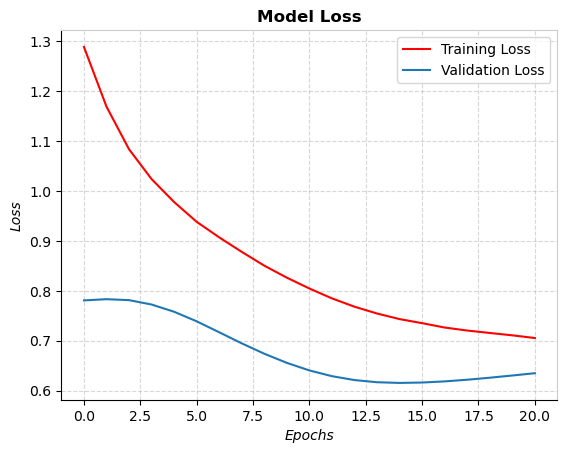

In [22]:

plt.plot(losses, label='Training Loss',color="red")
plt.plot(val_losses, label='Validation Loss')

plt.legend()

ax = plt.subplot(111)

# set the basic lables
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Model Loss')

# tweak the title
ttl = ax.title
ttl.set_weight('bold')

# tweak the axis labels
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(10)
ylab.set_style('italic')
ylab.set_size(10)

# grid on
ax.grid('on', linestyle = "--", alpha=0.5)

# color of plot, just to be sure
ax.set_facecolor('xkcd:white')

# change the color of the top and right spines to opaque gray
ax.spines['right'].set_color((.8,.8,.8))
ax.spines['top'].set_color((.8,.8,.8))


plt.savefig('epochs/{}.png'.format(name))
plt.show()

In [23]:
from tqdm import tqdm


# transformer = Transformer(num_layers=3, D=32, H=8, hidden_mlp_dim=64,
#                           inp_features=10, out_features=1, dropout_rate=0.1).to(device)
# optimizer = torch.optim.Adam(transformer.parameters(), 
#                                 lr=0.000001)

transformer.load_state_dict(torch.load('Models/transformer_{}.pth'.format(name)))


# Define function to retrain model on new data
def retrain_model(transformer, optimizer, train_dataset, num_epochs):
    transformer.train()  # Set model to training mode

    for e in tqdm(range(num_epochs)):
        # one epoch on train set
        transformer.train()
        sum_train_loss = 0.0
        for x,y in train_dataset:
            y = y.unsqueeze(-1) # tilføjet
            S = x.shape[1]
            mask = create_look_ahead_mask(S)
            out, _ = transformer(x, mask)
            loss = torch.nn.MSELoss()(out[-24:], y[-24:])
            sum_train_loss += loss.item()
            loss.backward()
            optimizer.step()
     

# Define rolling window parameters
window_size = 7  # One week's worth of data
stride = 7  # Advance one week at a time
num_weeks = (365-(2)) // stride
print(num_weeks)


# Initialize lists to store predictions and losses
test_losses = []
test_preds = []

# Evaluate model using rolling window approach
for i in range(num_weeks):
    
    start_idx = i * stride
    end_idx = start_idx + window_size

       
    test_subset = test_data[start_idx:end_idx,:,:]

    if i == 0: 
        new_train, _, test_subset = data_to_dataset(train_data, val_data, test_subset)
        
    if i != 0:
        new_train = np.append(test_subset,train_data,axis=0)
    
        new_train, _, test_subset = data_to_dataset(new_train, val_data, test_subset)

    
    # Evaluate model on current window
    transformer.eval()  # Set model to evaluation mode
    with torch.no_grad():
        window_losses = []
        window_preds = []
        for (x, y) in test_subset:
            y = y.unsqueeze(-1)
            S = x.shape[-2]
            y_pred, attention = transformer(x, mask=create_look_ahead_mask(S))
            loss = torch.nn.MSELoss()(y_pred, y)
            window_losses.append(loss.item())
            window_preds.append(y_pred.detach().cpu().numpy())
        test_losses.extend(window_losses)
        test_preds.extend(window_preds)


    # Retrain model on new data for this window
    transformer.train()  # Ensure model is in training mode
    retrain_model(transformer, optimizer, new_train, num_epochs=1)

51


100%|██████████| 1/1 [00:11<00:00, 11.95s/it]


In [24]:
save = test_preds
test_preds = np.vstack(save).copy()
print(test_preds.shape)

(357, 168, 1)


In [25]:
# evaluate one or more daily forecasts against expected values
def evaluate_forecast(actual, predicted):
    scores = list()
    
	# calculate an RMSE score for each hour
    for i in range(actual.shape[1]):
		# calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
        rmse = sqrt(mse)
		# store (changed to mse since it otherwise would not make sense on the plot)
        scores.append(rmse)
    
	# calculate overall RMSE
    sum = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            sum += (actual[row, col] - predicted[row, col])**2
    score = sqrt(sum / (actual.shape[0] * actual.shape[1]))
    
    # calculate error distribution
    error_dist = np.zeros_like(actual, dtype=float)
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            squared_error = (actual[row, col] - predicted[row, col])**2
            error_dist[row, col] = sqrt(squared_error)
    return score, scores, error_dist

In [26]:
# evaluate performance
def performance(name, score, scores):
 use_scores = ', '.join(['%.1f' % s for s in scores])
 print('%s: [%.3f] %s' % (name, score, use_scores))
    
 # Creating a dictionary of the data
 data = {'Model': [name],
        'Overall RMSE-score': [score]}

 # Dynamically create columns for scores
 data.update({f'RMSE Score {i}': [scores[i-1]] for i in range(1, 25)})

 # Creating a DataFrame from the dictionary
 df = pd.DataFrame(data)
    
 # Appending the new data to the DataFrame
 df.to_csv('Transformer_{}_output.csv'.format(data_type), mode='a', index=False, header=False)
  


In [27]:
# For plotting
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import datetime
from math import sqrt

pio.renderers.default='browser'
pio.templates.default = "seaborn"
plt.style.use('seaborn-v0_8-darkgrid')



predictions = np.array(test_preds) 

actuals = test_data[0:357,:,:]


_, _, actuals = data_to_dataset(train_data, val_data, actuals)
        

_, actuals = actuals.dataset.tensors
actualss = np.array(actuals) 


actualss = actualss[:,-24:] 
predictions = predictions[:,-24:,:] 

actualss = actualss.reshape(-1, 1)
predictions = predictions.reshape(-1, 1)

actualss = scaler.inverse_transform(actualss)
predictions = scaler.inverse_transform(predictions)



# Reshape the array into 24-hour sequences
num_hours_per_day = 24
num_days = actualss.size // num_hours_per_day
actualss = actualss.reshape(num_days, num_hours_per_day)
predictions = predictions.reshape(num_days, num_hours_per_day)


score, scores, error_dist = evaluate_forecast(actualss, predictions)


performance(name, score, scores)


predictions = predictions.flatten()
#predictions = predictions[:-12]

actuals = actualss.flatten()
#actuals = actuals[12:]

result = pd.DataFrame({'preds': predictions, 'actuals': actuals})

start_date = '2020-01-10 00:00:00'
end_date = '2020-12-31 23:59:00'
date_format = '%Y-%m-%d %H:%M:%S'


# Create datetime index
datetime_index = pd.date_range(start=start_date, end=end_date, freq='H')

# Create DataFrame with datetime index, predictions, and actuals
resultss = pd.DataFrame({'Datetime': datetime_index, 'Preds': predictions, 'Actuals': actuals})

# Save DataFrame to CSV file
resultss.to_csv('Predictions/{}_predictions_actuals.csv'.format(name), index=False)








start_datetime = datetime.datetime.strptime(start_date, date_format)
end_datetime = datetime.datetime.strptime(end_date, date_format)

date_range = pd.date_range(start=start_datetime, end=end_datetime, freq='H')



result = result.set_index(date_range)

fig = go.Figure([
    go.Scatter(
        name='Prediction',
        x=result.index,
        y=result["preds"],
        mode='lines',
    ),
    go.Scatter(
        name='Real value',
        x=result.index,
        y=result["actuals"],
        mode='lines',
     )
])


fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Demand",
    plot_bgcolor='white',
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    ),
    xaxis=dict(linecolor='black',showgrid=True, gridcolor='rgba(0, 0, 0, 0.3)',griddash='dash',mirror=True),
    yaxis=dict(linecolor='black',showgrid=True, gridcolor='rgba(0, 0, 0, 0.3)',griddash='dash',mirror=True),
)


fig.write_html('Predictions/Transformer_{}.html'.format(name), auto_open=True)


cam_but_right_24_hours_temp_more_head_les_mlp_less_dim_week_les_drop: [64.784] 47.7, 43.8, 40.5, 39.1, 39.9, 41.6, 44.4, 48.0, 54.9, 63.4, 72.6, 79.8, 81.8, 82.9, 81.8, 79.5, 77.7, 77.9, 78.2, 78.4, 73.0, 64.7, 60.0, 55.2


/tmp/ipykernel_1866500/3678691643.py:65: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/tmp/ipykernel_1866500/3678691643.py:83: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



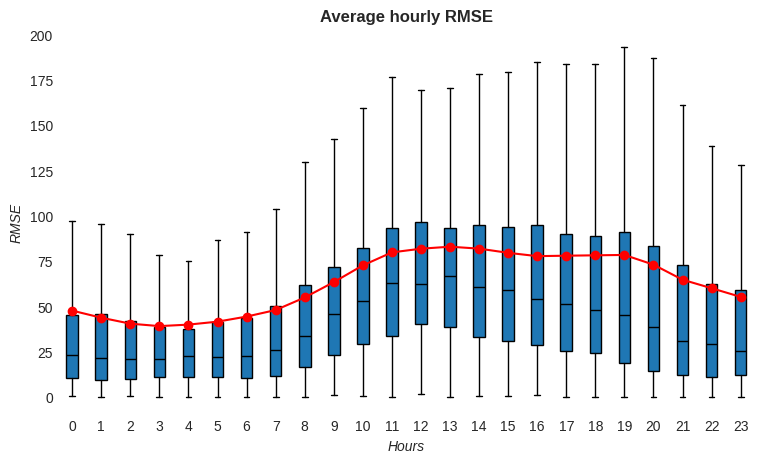

In [28]:
# plot scores

hours = ['00', '01', '02', '03', '04', '05', '06','07', '08', '09', '10', '11', '12', '13','14', '15', '16', '17', '18', '19', '20','21', '22', '23']
plt.figure(figsize=(9, 5))

boxplot_positions = np.arange(len(hours))
# Add boxplots for each column in the error_dist array
for col in range(error_dist.shape[1]):
    boxplot_values = error_dist[:, col]
    plt.boxplot(boxplot_values, positions=[col], widths=0.4, showfliers=False, patch_artist=True, medianprops=dict(color='black'))


plt.plot(hours, scores, marker='o', label='lstm', color="red")
ax = plt.subplot(111)

# set the basic lables
ax.set_xlabel('Hours')
ax.set_ylabel('RMSE')
ax.set_title('Average hourly RMSE')

# tweak the title
ttl = ax.title
ttl.set_weight('bold')

# tweak the axis labels
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(10)
ylab.set_style('italic')
ylab.set_size(10)

# grid on
ax.grid('on', linestyle = "--", alpha=0.5)

# color of plot, just to be sure
ax.set_facecolor('xkcd:white')

# change the color of the top and right spines to opaque gray
ax.spines['right'].set_color((.8,.8,.8))
ax.spines['top'].set_color((.8,.8,.8))


plt.savefig('scores/scores_{}.png'.format(name))
plt.show()

##### 